In [1]:
%matplotlib inline

/data/vision/torralba/naturally_robust_models/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import torch
import torch.nn as nn
import timm
import numpy as np
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import robustbench

device = torch.device('cuda', 6)

/data/vision/torralba/naturally_robust_models/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utils

In [3]:
def abs_normalize(x, q=None, start_dim=-3):
  s = torch.quantile(x.abs().flatten(start_dim=start_dim), q=max(q, 1-q), dim=-1, keepdim=False)
  x = 0.5 + 0.5 * x/s[(..., ) + (None,)*(-start_dim)]

  x = torch.clamp(x, 0., 1.)
  return x
  
def plot_side_by_side_normalize(*images, normalize):
  plt.figure(figsize=(20,20))
  assert len(images) == len(normalize)
  columns = len(images)
  for i, image in enumerate(images):
      plt.subplot(len(images) // columns + 1, columns, i + 1)
      image = image.detach()
      with torch.no_grad():
        if image.shape[-1] > 3:
          image = image.permute(1, 2, 0)
        if normalize[i]:
          image = abs_normalize(image, q=0.01)
        plt.imshow(image, cmap='gray')

In [4]:
from typing import Callable, Any

def get_output(module, input, output):
    return output

def get_input(module, input, output):
    return input

def get_input_output(module, input, output):
    return input, output

def get_module_input_output(module, input, output):
    return module, input, output

def register_hook_fn_to_module(model: nn.Module, module_name: str, hook_fn: Callable[[nn.Module, torch.Tensor, torch.Tensor], Any]):
    results_dict = {}
    for name, m in model.named_modules():
        if module_name == name:
            handle = m.register_forward_hook(_hook_fn_cntr(name, results_dict, hook_fn))
            return handle, results_dict

def register_bkw_hook_fn_to_module(model: nn.Module, module_name: str, hook_fn: Callable[[nn.Module, torch.Tensor, torch.Tensor], Any]):
    results_dict = {}
    for name, m in model.named_modules():
        if module_name == name:
            handle = m.register_full_backward_hook(_hook_fn_cntr(name, results_dict, hook_fn))
            return handle, results_dict

def register_hook_fn_to_all_modules(model: nn.Module, hook_fn: Callable[[nn.Module, torch.Tensor, torch.Tensor], Any]):
    results_dict = {}
    for name, m in model.named_modules():
        _ = m.register_forward_hook(_hook_fn_cntr(name, results_dict, hook_fn))
    return results_dict

def register_bkw_hook_fn_to_all_modules(model: nn.Module, hook_fn: Callable[[nn.Module, torch.Tensor, torch.Tensor], Any]):
    results_dict = {}
    for name, m in model.named_modules():
        _ = m.register_full_backward_hook(_hook_fn_cntr(name, results_dict, hook_fn))
    return results_dict

def _hook_fn_cntr(name, activation_dict, hook_fn):
    def hook(model, input, output):
        activation_dict[name] = hook_fn(model, input, output)
    return hook

In [5]:
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform


def replace_layers(model, old, new):
    for n, module in model.named_children():
        if len(list(module.children())) > 0:
            ## compound module, go inside it
            replace_layers(module, old, new)
            
        if isinstance(module, old):
            ## simple module
            setattr(model, n, new)

def add_imagenet_normalization(model):
  val_transform = create_transform(
    **resolve_data_config(model.pretrained_cfg, model=model),
    is_training=False,
  )

  normalize_transform = val_transform.transforms[-1]
  model = nn.Sequential(normalize_transform, model)
  return model

def load_model(path, ema=False):
    model_kwargs=dict({
            'num_classes': 1000,
            'drop_rate': 0.0,
            'drop_path_rate': 0.0,
            'drop_block_rate': None,
            'global_pool': None,
            'bn_momentum': None,
            'bn_eps': None,
    })
    if '_resnet_' in path:
      model = timm.models.create_model('resnet50', pretrained=False, **model_kwargs)
      if '_gelu' in path:
        replace_layers(model, nn.ReLU, nn.GELU())
    elif '_swinb' in path:
      model = timm.models.create_model('swin_base_patch4_window7_224', pretrained=False, **model_kwargs)
    elif '_swins' in path:
      model = timm.models.create_model('swin_small_patch4_window7_224', pretrained=False, **model_kwargs)
    ckpt = torch.load(path)
    if ema:
      if 'state_dict_ema' in ckpt:
        model.load_state_dict(ckpt['state_dict_ema'])
      else:
        return None
    else:
      model.load_state_dict(ckpt['state_dict'])

    model = add_imagenet_normalization(model)
    return model.eval().cpu()

def load_public_model(model_name):
  if model_name[0].isupper():
    return robustbench.utils.load_model(model_name, dataset='imagenet', threat_model='Linf').to(device)
  else:
    if 'random' in model_name:
      return add_imagenet_normalization(timm.create_model(model_name[:-len('_random')], pretrained=False).eval()).cpu()
    else:
      return add_imagenet_normalization(timm.create_model(model_name, pretrained=True).eval()).cpu()

## Data

In [6]:
data = torch.load('analysis_data/240206_gen_imagenet_data_10k_noattack.pth', map_location='cpu')
# xs = torch.load('/data/vision/torralba/naturally_robust_models/input_norm/outputs/inputs/train_png/inputs.pth')
# ys = torch.load('/data/vision/torralba/naturally_robust_models/input_norm/outputs/inputs/train_png/targets.pth')
# data = {'xs':xs, 'ys':ys}

In [7]:
data.keys()

dict_keys(['xs', 'ys', 'at_outs', 'at_grads', 'gn_outs', 'gn_grads', 'sampler_indices'])

In [8]:
xs = data['xs']
ys = data['ys']

N = 10000
xs = xs[:N]
ys = ys[:N]

model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)

val_transform = create_transform(
    **resolve_data_config(model.pretrained_cfg, model=model),
    is_training=False,
  )

normalize_transform = val_transform.transforms[-1]

if xs.min() < 0:
  xs = xs*normalize_transform.std[None, :, None, None] + normalize_transform.mean[None, :, None, None]

sampler_indices = range(N)
ds = torch.utils.data.TensorDataset(xs, ys)

from tqdm.auto import tqdm

dataloader = torch.utils.data.DataLoader(
    ds,
    batch_size=32,
    sampler=sampler_indices,
    shuffle=False
)

def get_activations(module_name, model_path=None, model_name=None):
  if model_path:
    model = load_model(model_path)
  elif model_name:
    model = load_public_model(model_name)

  model = model.to(device)

  handle, act_dict = register_hook_fn_to_module(model, module_name, get_input_output)
  
  outs = []
  grads = []
  act_inputs = []
  act_outputs = []

  for ii, (x, y) in enumerate(tqdm(dataloader)):
      x, y = x.to(device), y.to(device)
      x.requires_grad_(True)

      # Clean at
      out = model(x)#.cpu()
      loss = torch.nn.functional.cross_entropy(out, y)
      act_input = act_dict[module_name][0][0].detach().cpu()
      act_output = act_dict[module_name][1][0].detach().cpu() if isinstance(act_dict[module_name][1], tuple) else act_dict[module_name][1].detach().cpu()
      grad_x = torch.autograd.grad(loss, x, create_graph=False, retain_graph=False)[0].detach().cpu() #.abs().sum(1, keepdim=True)
      #logit = out[torch.arange(out.size(0)), y].sum()
      #grad_x = torch.autograd.grad(logit, x, create_graph=False, retain_graph=False)[0].detach().cpu().abs().max(1, keepdim=True).values

      outs.append(out.detach().cpu())
      grads.append(grad_x)
      act_inputs.append(act_input)
      act_outputs.append(act_output)
  
  outs = torch.cat(outs, 0)
  grads = torch.cat(grads, 0)
  act_inputs = torch.cat(act_inputs, 0)
  act_outputs = torch.cat(act_outputs, 0)
  handle.remove()

  model = model.to('cpu')

  return outs, grads, act_inputs, act_outputs

/data/vision/torralba/naturally_robust_models/.local/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
def measure_l1_norm(model_path=None, model_name=None):
    if model_path:
        model = load_model(model_path)
        print(model_path)
    elif model_name:
        model = load_public_model(model_name)
        print(model_name)

    outs = []
    grads = []

    corrects = []

    model = model.to(device)

    model.eval()
    for ii, (x, y) in enumerate(tqdm(dataloader)):
        x, y = x.to(device), y.to(device)
        x.requires_grad_(True)

        # Clean at
        out = model(x)#.cpu()
        correct = (out.argmax(-1) == y).float()
        loss = torch.nn.functional.cross_entropy(out, y, reduction='none')
        grad_x = torch.autograd.grad(loss.sum(), x, create_graph=False, retain_graph=False)[0].detach().cpu() #.abs().max(1, keepdim=True).values
        # logit = out[torch.arange(out.size(0)), y].sum()
        # grad_x = torch.autograd.grad(logit, x, create_graph=False, retain_graph=False)[0].detach().cpu().abs().max(1, keepdim=True).values
        

        outs.append(out.detach().cpu())
        corrects.append(correct.detach().cpu())
        grads.append(grad_x.detach().cpu())
        # if ii == 2:
        #     break

    outs = torch.cat(outs, 0)
    grads = torch.cat(grads, 0)

    model = model.to('cpu')

    return outs, grads

In [10]:
running_mean = torch.zeros((3,))
running_std = torch.zeros((3,))
for ii, (x, y) in enumerate(tqdm(dataloader)):
  running_mean += x.mean((0, 2, 3))
  running_std += x.std((0, 2, 3))
running_mean = running_mean * 32 / 10000
running_std = running_std * 32 / 10000

100%|██████████| 313/313 [00:04<00:00, 68.86it/s]


In [11]:
running_mean, running_std, x.min(), x.max()

(tensor([0.4749, 0.4466, 0.3962]),
 tensor([0.2718, 0.2645, 0.2758]),
 tensor(0.),
 tensor(1.))

In [12]:
load_model(f'outputs/gradnorm_swinb_orig/last.pth.tar')[0]

Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))

In [13]:
nat_outs, nat_grads = measure_l1_norm(model_name='swin_base_patch4_window7_224')

swin_base_patch4_window7_224


100%|██████████| 313/313 [01:04<00:00,  4.82it/s]


In [14]:
nat_grads.abs().sum((-3, -2, -1)).mean(), (nat_outs.argmax(-1) == ys).float().mean()

(tensor(3891.8076), tensor(0.8531))

In [15]:
at_outs, at_grads = measure_l1_norm(model_path='outputs/advtrain_swinb_orig/last.pth.tar')

eccv_outputs/advtrain_swinb_orig/last.pth.tar


100%|██████████| 313/313 [01:05<00:00,  4.81it/s]


In [16]:
at_grads.abs().sum((-3, -2, -1)).mean(), (at_outs.argmax(-1) == ys).float().mean()

(tensor(35.9050), tensor(0.7705))

In [17]:
gns_outs, gns_grads = measure_l1_norm(f'outputs/gradnorm_swinb_variant/2024-02-14_11-30-41/last.pth.tar')
gns_grads.abs().sum((-3, -2, -1)).mean()

eccv_outputs/gradnorm_swinb_variant/2024-02-14_11-30-41/last.pth.tar


100%|██████████| 313/313 [01:05<00:00,  4.79it/s]


tensor(36.4554)

In [18]:
gns_grads.abs().sum((-3, -2, -1)).mean(), (gns_outs.argmax(-1) == ys).float().mean()

(tensor(36.4554), tensor(0.7764))

In [19]:
gnw_outs, gnw_grads = measure_l1_norm(model_path=f'outputs/gradnorm_swinb_orig/last.pth.tar')
gnw_grads.abs().sum((-3, -2, -1)).mean()

eccv_outputs/gradnorm_swinb_orig/last.pth.tar


100%|██████████| 313/313 [01:04<00:00,  4.82it/s]


tensor(36.7373)

In [20]:
gnw_grads.abs().sum((-3, -2, -1)).mean(), (gnw_outs.argmax(-1) == ys).float().mean()

(tensor(36.7373), tensor(0.7756))

In [21]:
from typing import Tuple
import torch.nn.functional as F

def curvature_hessian_estimator(model: torch.nn.Module,
                        image: torch.Tensor,
                        target: torch.Tensor,
                        num_power_iter: int=20) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:

    model.eval()
    u = torch.randn_like(image)
    u /= torch.norm(u, p=2, dim=(1, 2, 3), keepdim=True)

    with torch.enable_grad():
        image = image.requires_grad_()
        out = model(image)
        # print((out.argmax(-1) == target).float().mean(), target)
        y = F.log_softmax(out, 1)
        output = F.nll_loss(y, target, reduction='none')
        model.zero_grad()
        # Gradients w.r.t. input
        gradients = torch.autograd.grad(outputs=output.sum(),
                                        inputs=image, create_graph=True)[0]
        gnorm = torch.norm(gradients, p=2, dim=(1, 2, 3))
        gnorm_1 = gradients.abs().sum((1, 2, 3))
        assert not gradients.isnan().any()

        # Power method to find singular value of Hessian
        for _ in range(num_power_iter):
            grad_vector_prod = (gradients * u.detach_()).sum()
            hessian_vector_prod = torch.autograd.grad(outputs=grad_vector_prod, inputs=image, retain_graph=True)[0]
            assert not hessian_vector_prod.isnan().any()

            hvp_norm = torch.norm(hessian_vector_prod, p=2, dim=(1, 2, 3), keepdim=True)
            u = hessian_vector_prod.div(hvp_norm + 1e-6) #1e-6 for numerical stability

        grad_vector_prod = (gradients * u.detach_()).sum()
        hessian_vector_prod = torch.autograd.grad(outputs=grad_vector_prod, inputs=image)[0]
        hessian_singular_value = (hessian_vector_prod * u.detach_()).sum((1, 2, 3))
    
    # curvature = hessian_singular_value / (grad_norm + epsilon) by definition
    curvatures = hessian_singular_value.abs().div(gnorm + 1e-6)
    hess = hessian_singular_value.abs()
    grad = gnorm
    grad_1 = gnorm_1
    
    return curvatures, hess, grad, grad_1


def measure_curvature(model: torch.nn.Module,
                      dataloader: torch.utils.data.DataLoader,
                      data_fraction: float=0.1,
                      batch_size: int=64,
                      num_power_iter: int=20,
                      device: torch.device='cpu') -> Tuple[tuple, tuple, tuple]:

    """
    Compute curvature, hessian norm and gradient norm of a subset of the data given by the dataloader.
    These values are computed using the power method, which requires setting the number of power iterations (num_power_iter).
    """

    model.eval()
    datasize = int(data_fraction * len(dataloader.dataset))
    max_batches = int(datasize / batch_size)
    curvature_agg = torch.zeros(size=(datasize,))
    grad_agg = torch.zeros(size=(datasize,))
    hess_agg = torch.zeros(size=(datasize,))
    grad_1_agg = torch.zeros(size=(datasize,))

    for idx, (data, target) in enumerate(tqdm(dataloader)):
        data, target = data.to(device).requires_grad_(), target.to(device)
        with torch.no_grad():
            curvatures, hess, grad, grad_1 = curvature_hessian_estimator(model, data, target, num_power_iter=num_power_iter)
        curvature_agg[idx * batch_size:(idx + 1) * batch_size] = curvatures.detach()
        hess_agg[idx * batch_size:(idx + 1) * batch_size] = hess.detach()
        grad_agg[idx * batch_size:(idx + 1) * batch_size] = grad.detach()
        grad_1_agg[idx * batch_size:(idx + 1) * batch_size] = grad_1.detach()

        avg_curvature, std_curvature = curvature_agg.mean().item(), curvature_agg.std().item()
        avg_hessian, std_hessian = hess_agg.mean().item(), hess_agg.std().item()
        avg_grad, std_grad = grad_agg.mean().item(), grad_agg.std().item()
        avg_grad_1, std_grad_1 = grad_1_agg.mean().item(), grad_1_agg.std().item()

        if idx == (max_batches - 1):
            print('Average Curvature: {:.6f} +/- {:.2f} '.format(avg_curvature, std_curvature))
            print('Average Hessian Spectral Norm: {:.6f} +/- {:.2f} '.format(avg_hessian, std_hessian))
            print('Average Gradient Norm: {:.6f} +/- {:.2f}'.format(avg_grad, std_grad))
            print('Average Gradient L1 Norm: {:.6f} +/- {:.2f}'.format(avg_grad_1, std_grad_1))
            return curvature_agg, hess_agg, grad_agg, grad_1_agg

In [22]:
def launch_measure_curvature(model_path=None, model_name=None):
  if model_path:
    model = load_model(model_path)
    print(model_path)
  elif model_name:
    model = load_public_model(model_name)
    print(model_name)

  model = model.to(device)

  return measure_curvature(model, dataloader, data_fraction=3200./10000., batch_size=dataloader.batch_size, device=device)

In [23]:
launch_measure_curvature(model_name='swin_base_patch4_window7_224')

swin_base_patch4_window7_224


 32%|███▏      | 99/313 [15:01<32:27,  9.10s/it]

Average Curvature: 17673.175781 +/- 96353.66 
Average Hessian Spectral Norm: 1436205.125000 +/- 21786998.00 
Average Gradient Norm: 28.674477 +/- 93.81
Average Gradient L1 Norm: 4113.767090 +/- 9481.14


(tensor([ 6478.2798,  3057.1111, 12856.1201,  ...,  1372.2876,  1593.4756,
          2873.5393]),
 tensor([156733.6562,  17198.1816, 331758.2500,  ...,   1820.6069,
           6047.1543,  51871.5469]),
 tensor([24.1937,  5.6256, 25.8055,  ...,  1.3267,  3.7949, 18.0514]),
 tensor([2491.3491,  571.9424, 5069.7207,  ...,  228.1461,  624.6285,
         3779.5981]))

In [24]:
results_dict = {}

In [25]:
def linear_stats(k):
  x = results_dict[k]
  return x.mean().item(), x.std().item()

def log_stats(k):
  x = results_dict[k][0] + 1e-17
  return x.log10().mean().item(), x.log10().std().item(),  x.mean().item()

In [26]:
results_dict['natural'] = launch_measure_curvature(model_name='swin_base_patch4_window7_224')
# swin_base_patch4_window7_224
#   1%|          | 9/1000 [00:29<53:48,  3.26s/it]
# Average Curvature: 329.745911 +/- 848.00 
# Average Hessian Spectral Norm: 2281.421875 +/- 16798.63 
# Average Gradient Norm: 2.281582 +/- 5.38

swin_base_patch4_window7_224


 32%|███▏      | 99/313 [14:59<32:25,  9.09s/it]

Average Curvature: 17665.507812 +/- 96353.48 
Average Hessian Spectral Norm: 1436044.750000 +/- 21787018.00 
Average Gradient Norm: 28.674477 +/- 93.81
Average Gradient L1 Norm: 4113.767090 +/- 9481.14


In [27]:
log_stats('natural')

(3.6610682010650635, 0.6375203728675842, 17665.5078125)

In [28]:
results_dict['advtrain'] = launch_measure_curvature(model_path=f'outputs/advtrain_swinb_orig/last.pth.tar')

eccv_outputs/advtrain_swinb_orig/last.pth.tar


 32%|███▏      | 99/313 [14:59<32:25,  9.09s/it]

Average Curvature: 2.165303 +/- 1.82 
Average Hessian Spectral Norm: 0.750861 +/- 1.72 
Average Gradient Norm: 0.309373 +/- 0.44
Average Gradient L1 Norm: 36.656002 +/- 47.84


In [29]:
log_stats('advtrain')

(0.23515693843364716, 0.31273946166038513, 2.1653025150299072)

In [30]:
results_dict['gradnorm_strong'] = launch_measure_curvature(model_path=f'outputs/gradnorm_swinb_variant/2024-02-14_11-30-41/last.pth.tar')

eccv_outputs/gradnorm_swinb_variant/2024-02-14_11-30-41/last.pth.tar


 32%|███▏      | 99/313 [14:59<32:24,  9.08s/it]

Average Curvature: 2.149716 +/- 1.72 
Average Hessian Spectral Norm: 0.787794 +/- 3.25 
Average Gradient Norm: 0.305790 +/- 0.67
Average Gradient L1 Norm: 38.010830 +/- 64.87


In [31]:
log_stats('gradnorm_strong')

(0.23440857231616974, 0.30399277806282043, 2.149716377258301)

In [ ]:
# results_dict['gradnorm_weak'] = launch_measure_curvature(model_path=f'outputs/gradnorm_swinb_orig/last.pth.tar')

In [ ]:
# log_stats('gradnorm_weak')

(0.20622465014457703, 0.29911452531814575, 2.0155746936798096)

In [ ]:
# _ = launch_measure_curvature(model_name='swin_base_patch4_window7_224')

swin_base_patch4_window7_224


 32%|███▏      | 99/313 [15:02<32:31,  9.12s/it]

Average Curvature: 17671.580078 +/- 96353.47 
Average Hessian Spectral Norm: 1436146.500000 +/- 21787008.00 
Average Gradient Norm: 28.674477 +/- 93.81
Average Gradient L1 Norm: 4113.767090 +/- 9481.14


In [55]:
def plot_fn(name, fn, *, index=Ellipsis, split=None, **kwargs):
    _at_linerrs = results_dict['advtrain'][0][index].detach().cpu()
    _gn_strong_linerrs = results_dict['gradnorm_strong'][0][index].detach().cpu()
    _nat_linerrs = results_dict['natural'][0][index].detach().cpu()
    print(_at_linerrs.shape, _gn_strong_linerrs.shape, _nat_linerrs.shape)
    print(_at_linerrs.min(), _gn_strong_linerrs.min(), _nat_linerrs.min())
    if split is None:
        split = _at_linerrs.shape[0]
    at_fn_v = torch.cat([fn(_x) for _x in _at_linerrs.split(split, dim=0)], 0)
    gns_fn_v = torch.cat([fn(_x) for _x in _gn_strong_linerrs.split(split, dim=0)], 0)
    nat_fn_v = torch.cat([fn(_x) for _x in _nat_linerrs.split(split, dim=0)], 0)
    ax = sns.displot(data=pd.DataFrame(
        {
            name: torch.cat([at_fn_v, gns_fn_v, nat_fn_v], 0),
            "Training": (
                ([f'Adversarial Training (PGD-3) (mean={at_fn_v.mean():.2e})'] * _at_linerrs.shape[0]) + 
                ([f'Gradient Norm Regularization (mean={gns_fn_v.mean():.2e})'] * _gn_strong_linerrs.shape[0]) +
                ([f'Natural Training (mean={nat_fn_v.mean():.2e})'] * _nat_linerrs.shape[0])
            ),
        }), kde=True, x=name, hue='Training', 
        palette = {
            f'Adversarial Training (PGD-3) (mean={at_fn_v.mean():.2e})':'red', 
            f'Gradient Norm Regularization (mean={gns_fn_v.mean():.2e})':'blue',
            f'Natural Training (mean={nat_fn_v.mean():.2e})':'orange'
        }, **kwargs)
    plt.gca().set_ylabel(f'Count (n={_at_linerrs.shape[0]})')
    return ax.fig

torch.Size([3200]) torch.Size([3200]) torch.Size([3200])
tensor(0.0005) tensor(0.0067) tensor(24.2312)


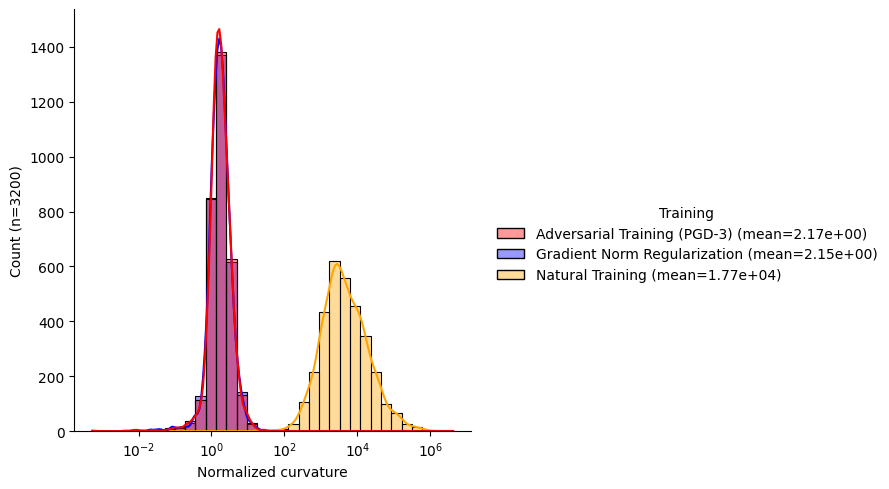

In [56]:
fig = plot_fn(r'Normalized curvature', lambda x: x + 1e-16, 
        index=torch.arange(3200), log_scale=(True, False), alpha=0.4)
fig.savefig('./figures_suppmat/curvature.pdf', facecolor='white')

In [59]:
def plot_fn(name, fn, *, index=Ellipsis, split=None, **kwargs):
    _at_linerrs = results_dict['advtrain'][0][index].detach().cpu()
    _gn_strong_linerrs = results_dict['gradnorm_strong'][0][index].detach().cpu()
    print(_at_linerrs.shape, _gn_strong_linerrs.shape)
    print(_at_linerrs.min(), _gn_strong_linerrs.min())
    if split is None:
        split = _at_linerrs.shape[0]
    at_fn_v = torch.cat([fn(_x) for _x in _at_linerrs.split(split, dim=0)], 0)
    gns_fn_v = torch.cat([fn(_x) for _x in _gn_strong_linerrs.split(split, dim=0)], 0)
    ax = sns.displot(data=pd.DataFrame(
        {
            name: torch.cat([at_fn_v, gns_fn_v], 0),
            "Training": (
                ([f'Adversarial Training (PGD-3) (mean={at_fn_v.mean():.2e})'] * _at_linerrs.shape[0]) + 
                ([f'Gradient Norm Regularization (mean={gns_fn_v.mean():.2e})'] * _gn_strong_linerrs.shape[0])
            ),
        }), kde=True, x=name, hue='Training', 
        palette = {
            f'Adversarial Training (PGD-3) (mean={at_fn_v.mean():.2e})':'red', 
            f'Gradient Norm Regularization (mean={gns_fn_v.mean():.2e})':'blue',
        }, **kwargs)
    plt.gca().set_ylabel(f'Count (n={_at_linerrs.shape[0]})')
    return ax.fig

torch.Size([3200]) torch.Size([3200])
tensor(0.0005) tensor(0.0067)


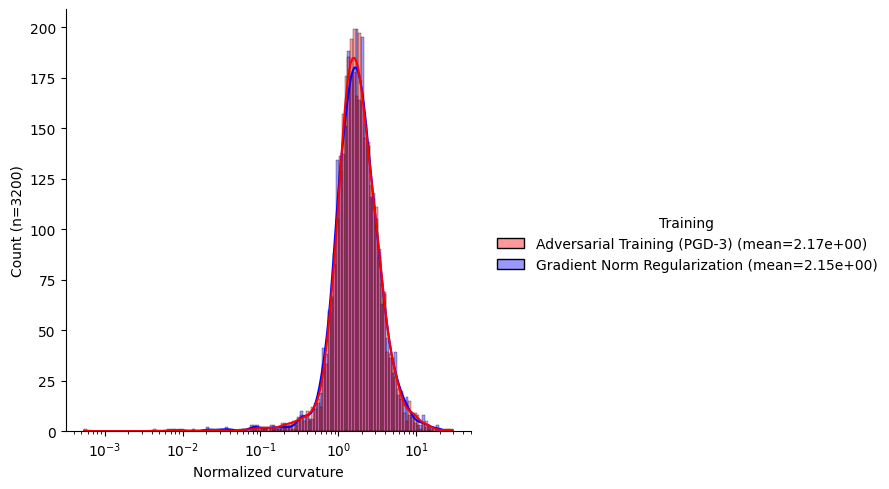

In [60]:
fig = plot_fn(r'Normalized curvature', lambda x: x + 1e-16, 
        index=torch.arange(3200), log_scale=(True, False), alpha=0.4)
fig.savefig('./figures_suppmat/curvature_nonat.pdf', facecolor='white')